In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ["JAX_TRACEBACK_FILTERING"] = "off"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.1"

from hydra import initialize, compose
import jax
import jax.numpy as jnp
import numpy as np
from functools import partial
# from corrector_src.utils.power_spectra_1d import pk1d_jax
import Pk_library as PKL
import matplotlib.pyplot as plt

In [2]:
def pk_jax_1d(
    delta: jnp.ndarray, BoxSize: float = 1.0, axis: int = 2, verbose: bool = True
):
    """
    Compute 1D power spectrum along a specified axis using JAX.

    Parameters:
    -----------
    delta : jnp.ndarray
        3D density field
    BoxSize : float
        Size of the simulation box
    axis : int
        Axis along which to compute parallel modes (0=x, 1=y, 2=z)
    verbose : bool
        Print diagnostic information

    Returns:
    --------
    k1D : jnp.ndarray
        Wavenumbers
    Pk1D : jnp.ndarray
        Power spectrum values
    Nmodes1D : jnp.ndarray
        Number of modes in each bin
    """
    dims = delta.shape[0]
    middle = dims // 2
    kF = 2.0 * jnp.pi / BoxSize
    kN = middle * kF
    kmax_par = middle

    # --- FFT of the field ---
    delta_k = jnp.fft.fftn(delta)

    # Build integer frequency grids matching Cython code
    # The Cython code uses: kx = (kxx-dims if (kxx>middle) else kxx)
    # This creates frequencies in range [-middle, middle] for even dims
    kx_indices = jnp.arange(dims)
    ky_indices = jnp.arange(dims)
    kz_indices = jnp.arange(dims)

    kx = jnp.where(kx_indices > middle, kx_indices - dims, kx_indices)
    ky = jnp.where(ky_indices > middle, ky_indices - dims, ky_indices)
    kz = jnp.where(kz_indices > middle, kz_indices - dims, kz_indices)

    KX, KY, KZ = jnp.meshgrid(kx, ky, kz, indexing="ij")

    # ---- Build independent modes mask (matching Cython logic) ----
    mask = jnp.ones_like(KX, dtype=bool)

    # The Cython code only loops over kzz in range(middle+1), effectively kz >= 0
    # So we only keep kz >= 0 modes
    mask = jnp.where(KZ < 0, False, mask)

    # Handle special planes for Hermitian symmetry
    # kz=0 plane: exclude kx < 0
    kz_zero = KZ == 0
    mask = jnp.where(kz_zero & (KX < 0), False, mask)

    # kz=0 or kz=middle plane with kx=0 or kx=middle: exclude ky < 0
    kz_middle = (KZ == middle) & (dims % 2 == 0)
    special_plane = kz_zero | kz_middle
    kx_special = (KX == 0) | ((KX == middle) & (dims % 2 == 0))
    mask = jnp.where(special_plane & kx_special & (KY < 0), False, mask)

    # Keep only modes with |k| <= middle
    k_mag = jnp.sqrt(KX**2 + KY**2 + KZ**2)
    mask = jnp.where(k_mag > middle, False, mask)

    # Compute k_par based on chosen axis
    if axis == 0:
        k_par = jnp.abs(KX)
    elif axis == 1:
        k_par = jnp.abs(KY)
    else:  # axis == 2
        k_par = jnp.abs(KZ)

    # Compute |delta_k|^2
    delta2 = jnp.abs(delta_k) ** 2

    # Apply mask
    delta2_masked = jnp.where(mask, delta2, 0.0)
    k_par_masked = jnp.where(mask, k_par, 0)
    mask_float = mask.astype(jnp.float64)

    # Bin by k_par using vmap approach
    def bin_sum(i):
        in_bin = (k_par_masked == i) & mask
        return jnp.sum(jnp.where(in_bin, delta2_masked, 0.0))

    def bin_k_sum(i):
        in_bin = (k_par_masked == i) & mask
        return jnp.sum(jnp.where(in_bin, k_par * mask_float, 0.0))

    def bin_count(i):
        in_bin = (k_par_masked == i) & mask
        return jnp.sum(in_bin.astype(jnp.float64))

    # Compute for all bins
    indices = jnp.arange(kmax_par + 1)
    Pk1D = jax.vmap(bin_sum)(indices)
    k1D = jax.vmap(bin_k_sum)(indices)
    Nmodes1D = jax.vmap(bin_count)(indices)

    # Remove DC mode (k_par = 0)
    k1D = k1D[1:]
    Pk1D = Pk1D[1:]
    Nmodes1D = Nmodes1D[1:]

    # Compute average k in each bin and apply units
    k1D = jnp.where(Nmodes1D > 0, k1D / Nmodes1D, 0.0) * kF

    # Compute perpendicular sampling area (matching Cython logic)
    # kmaxper = sqrt(kN^2 - k1D^2), where kN is the Nyquist frequency
    kmaxper = jnp.sqrt(jnp.maximum(kN**2 - k1D**2, 0.0))

    # Normalize power spectrum exactly as in Cython code:
    # Pk1D[i] = Pk1D[i]*(BoxSize/dims**2)**3 * (pi*kmaxper^2/Nmodes) / (2*pi)^2
    Pk1D = jnp.where(
        Nmodes1D > 0,
        Pk1D
        * (BoxSize / dims**2) ** 3
        * (jnp.pi * kmaxper**2 / Nmodes1D)
        / (2.0 * jnp.pi) ** 2,
        0.0,
    )

    if verbose:
        print(f"Box size: {BoxSize}, Grid dims: {dims}")
        print(f"kF: {kF:.4f}, kN: {kN:.4f}, middle: {middle}")
        print(f"Nmodes along axis {axis} (first 10): {Nmodes1D[:10]}")
        print(f"Nmodes along axis {axis} (last 5): {Nmodes1D[-5:]}")
        print(f"k1D (first 5): {k1D[:5]}")
        print(f"k1D (last 5): {k1D[-5:]}")
        print(f"Pk1D (first 5): {Pk1D[:5]}")
        print(f"Total modes included: {jnp.sum(mask)}")

    return k1D, Pk1D, Nmodes1D


In [3]:
with initialize(version_base=None, config_path="../../configs"):
    cfg = compose(config_name="config")
    print(cfg)


{'experiment': {'name': 'turbulence_force_corrector'}, 'data': {'debug': '${training.debug}', 'hr_res': 160, 'downscaling_factor': 2, 'num_checkpoints': 10, 'num_timesteps': 1000, 'generate_data_on_fly': True, 'precomputed_data': False, 'fixed_timestep': False, 'dt_max': 0.1, 't_end': 1.0, 'snapshot_timepoints': [1.0], 'num_snapshots': 1, 'use_specific_snapshot_timepoints': True, 'return_snapshots': True, 'scenarios': [1]}, 'training': {'epochs': 300, 'n_look_behind': 10, 'learning_rate': 0.001, 'return_full_sim': False, 'return_full_sim_epoch_interval': 10, 'rng_key': 60, 'debug': False, 'mse_loss': 1, 'spectral_energy_loss': 0.01, 'rate_of_strain_loss': 0.01, 'early_stopping': True}, 'models': {'_target_': 'corrector_src.model.fno_hd_force_corrector.TurbulenceSGSForceCorrectorFNO', '_name_': 'fno', 'hidden_channels': 8, 'n_fourier_layers': 1, 'fourier_modes': 4, 'shifting_modes': 2}}


In [ ]:
from jf1uids.initial_condition_generation.turb import create_turb_field


turbulence_slope = -2
kmin = 2
kmax = 64

key = jax.random.key(666)

keys = jax.random.split(key, 3)
u_x = create_turb_field(32, 1, turbulence_slope, kmin, kmax, jax.random.key(666))

[  6.2831855  12.566371   18.849556   25.13274    31.415928   37.699112
  43.9823     50.265484   56.548668   62.831856   69.11504    75.398224
  81.68141    87.9646     94.24779   100.53097  ] [  6.2831855  12.566371   18.849556   25.13274    31.415928   37.699112
  43.9823     50.265484   56.548668   62.831856   69.11504    75.398224
  81.68141    87.9646     94.24779   100.53097  ]


/export/home/jalegria/miniconda3/envs/thesis_2/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [ ]:
k_jax, P_jax, modes_jax = pk_jax_1d(u_x, axis=0)
pk = PKL.Pk(
    np.array(u_x, dtype="float32"),
    BoxSize=1,
    axis=0,
    MAS="None",
    threads=6,
    verbose=False,
)
k_pk = pk.k1D
pk_pk = pk.Pk1D


/export/home/jalegria/miniconda3/envs/thesis_2/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Box size: 1.0, Grid dims: 32
kF: 6.2832, kN: 100.5310, middle: 16
Nmodes along axis 0 (first 10): [793. 793. 777. 749. 725. 681. 657. 593. 553. 489.]
Nmodes along axis 0 (last 5): [349. 277. 185.  97.   1.]
k1D (first 5): [ 6.2831855 12.566371  18.849556  25.13274   31.415928 ]
k1D (last 5): [ 75.398224  81.68141   87.9646    94.24779  100.53097 ]
Pk1D (first 5): [4.2116161e-10 3.0297193e-10 1.4570078e-10 8.6950724e-11 5.7596292e-11]
Total modes included: 8539


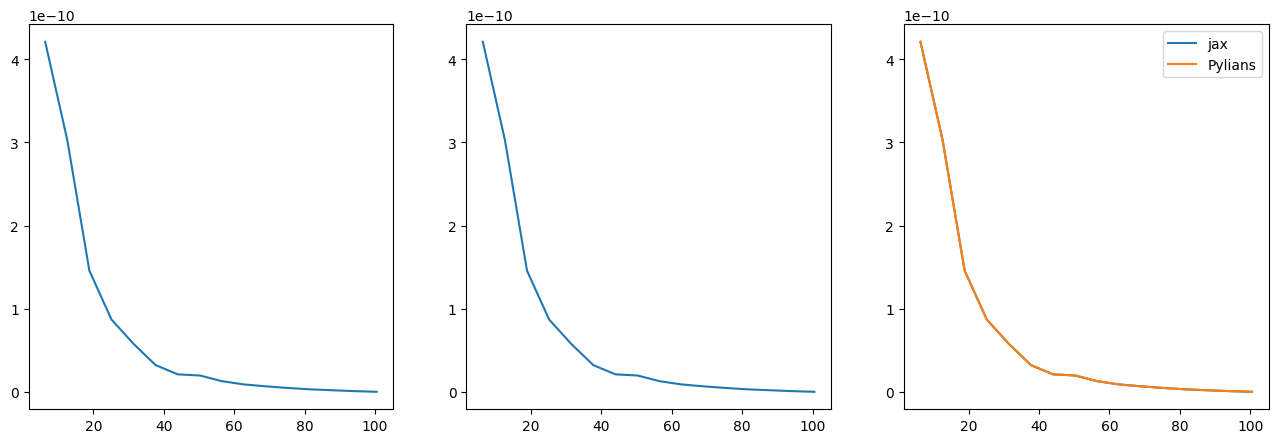

In [6]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize = (16, 5))
axes[0].plot(k_jax, P_jax, label="jax")
axes[1].plot(k_pk, pk_pk, label="Pylians")
axes[2].plot(k_jax, P_jax, label="jax")
axes[2].plot(k_pk, pk_pk, label="Pylians")
axes[2].legend()